In [73]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET
from Bio.PDB import *
import nglview as nv
import math
import warnings
import imageio
from matplotlib.pyplot import figure
from matplotlib import animation
import scipy
from Bio.PDB.StructureBuilder import PDBConstructionWarning
from Bio.PDB.DSSP import DSSP
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
warnings.filterwarnings("ignore", category=PDBConstructionWarning)
import json

In [74]:
dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
fasta_path = os.path.join(data_path, 'FASTA/')
dssp_path = os.path.join(data_path, 'DSSP/')
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
if not os.path.exists(dssp_path):
    os.makedirs(dssp_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')

In [3]:
################################################################################
def determine_number_of_channels(input_features, pdb_list, length_dict):
    F = 0
    x = input_features[pdb_list[0]]
    l = length_dict[pdb_list[0]]
    for feature in x:
        if len(feature) == l:
            F += 2
        elif len(feature) == l * l:
            F += 1
        else:
            print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
            sys.exit(1)
    return F

################################################################################
def print_max_avg_sum_of_each_channel(x):
    print(' Channel        Avg        Max        Sum')
    for i in range(len(x[0, 0, :])):
        (m, s, a) = (x[:, :, i].flatten().max(), x[:, :, i].flatten().sum(), x[:, :, i].flatten().mean())
        print(' %7s %10.4f %10.4f %10.1f' % (i, a, m, s))

################################################################################
# Roll out 1D features to two 2D features, all to 256 x 256 (because many are smaller)
def prepare_input_features_2D(pdbs, input_features, distance_maps_cb, length_dict, F):
    X = np.full((len(pdbs), 256, 256, F), 0.0)
    Y = np.full((len(pdbs), 256, 256, 1), 100.0)
    for i, pdb in enumerate(pdbs):
        x = input_features[pdb]
        y = distance_maps_cb[pdb]
        l = length_dict[pdb]
        newi = 0
        xmini = np.zeros((l, l, F))
        for feature in x:
            feature = np.array(feature)
            feature = feature.astype(np.float)
            if len(feature) == l:
                for k in range(0, l):
                    xmini[k, :, newi] = feature
                    xmini[:, k, newi + 1] = feature
                newi += 2
            elif len(feature) == l * l:
                xmini[:, :, newi] = feature.reshape(l, l)
                newi += 1
            else:
                print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
                sys.exit(1)
        if l > 256:
            l = 256
        X[i, 0:l, 0:l, :] = xmini[:l, :l, :]
        Y[i, 0:l, 0:l, 0] = y[:l, :l]
    return X, Y

################################################################################
# Prepare data for Mapper input of 2D array
def prepare_input_features_1D(pdbs, input_features, distance_maps_cb, length_dict, F):
    X = np.full((len(pdbs), 256, 256, F), 0.0)
    Y = np.full((len(pdbs), 256, 256, 1), 100.0)
    for i, pdb in enumerate(pdbs):
        x = input_features[pdb]
        y = distance_maps_cb[pdb]
        l = length_dict[pdb]
        #print(len(y))
        newi = 0
        xmini = np.zeros((l, l, F))
        for feature in x:
            feature = np.array(feature)
            feature = feature.astype(np.float)
            for k in range(0, l):
                xmini[k, :, newi] = feature
                xmini[:, k, newi + 1] = feature
            newi += 2
        if l > 256:
            l = 256
        X[i, 0:l, 0:l, :] = xmini[:l, :l, :]
        Y[i, 0:l, 0:l, 0] = y[:l, :l]
    return X, Y

################################################################################
def plot_input_output_of_this_protein(X, Y):
    figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
    for i in range(13):
        plt.subplot(7, 7, i + 1)
        plt.grid(None)
        plt.imshow(X[:, :, i], cmap='RdYlBu', interpolation='nearest')
    # Last plot is the true distance map
    plt.subplot(7, 7, 14)
    plt.grid(None)
    plt.imshow(Y[:, :], cmap='Spectral', interpolation='nearest')
    plt.show()

################################################################################
def calculate_mae(PRED, YTRUE, pdb_list, length_dict):
    plot_count = 0
    if flag_show_plots:
        plot_count = 4
    avg_mae = 0.0
    for i in range(0, len(PRED[:, 0, 0, 0])):
        L = length_dict[pdb_list[i]]
        P = np.zeros((L, L))
        # Average the predictions from both triangles (optional)
        # This can improve MAE by upto 6% reduction
        for j in range(0, L):
            for k in range(0, L):
                P[k, j] = (PRED[i, k, j, 0] + PRED[i, j, k, 0]) / 2.0
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        for j in range(0, L):
            for k in range(0, L):
                if k - j < 24:
                    P[j, k] = np.inf
                    Y[j, k] = np.inf
        p_dict = {}
        y_dict = {}
        for j in range(0, L):
            for k in range(0, L):
                p_dict[(j,k)] = P[j, k]
                y_dict[(j,k)] = Y[j, k]
        top_pairs = []
        x = L
        for pair in sorted(p_dict.items(), key=lambda x: x[1]):
            (k, v) = pair
            top_pairs.append(k)
            x -= 1
            if x == 0:
                break
        sum_mae = 0.0
        for pair in top_pairs:
            abs_dist = abs(y_dict[pair] - p_dict[pair])
            sum_mae += abs_dist
        sum_mae /= L
        avg_mae += sum_mae
        print('MAE for ' + str(i) + ' - ' + str(pdb_list[i]) + ' = %.2f' % sum_mae)
        if plot_count > 0:
            plot_count -= 1
            for j in range(0, L):
                for k in range(0, L):
                    if not (j, k) in top_pairs:
                        P[j, k] = np.inf
                        Y[j, k] = np.inf
            for j in range(0, L):
                for k in range(j, L):
                    P[k, j] = Y[j, k]
            plt.grid(None)
            plt.imshow(P, cmap='RdYlBu', interpolation='nearest')
            plt.show()
    print('Average MAE = %.2f' % (avg_mae / len(PRED[:, 0, 0, 0])))

In [4]:
(pdb_list, length_dict, input_features) = np.load(feature_path, encoding='latin1')
(pdb_list_y, distance_maps_cb) = np.load(distance_path, encoding='latin1')

In [8]:
split = int(0.04 * len(pdb_list))
valid_pdbs = pdb_list[:split]
train_pdbs = pdb_list[split:]

print('Total validation proteins = ', len(valid_pdbs))
print('Total training proteins = ', len(train_pdbs))

F = determine_number_of_channels(input_features, pdb_list, length_dict)

Total validation proteins =  8
Total training proteins =  192


In [9]:
XVALID, YVALID = prepare_input_features_2D(valid_pdbs, input_features, distance_maps_cb, length_dict, F)
print(XVALID.shape)
print(YVALID.shape)

(8, 256, 256, 13)
(8, 256, 256, 1)


In [10]:
XTRAIN, YTRAIN = prepare_input_features_2D(train_pdbs, input_features, distance_maps_cb, length_dict, F)
print(XTRAIN.shape)
print(YTRAIN.shape)

(192, 256, 256, 13)
(192, 256, 256, 1)


In [11]:
print(' First validation protein:')
print_max_avg_sum_of_each_channel(XVALID[0, :, :, :])
print(' First traininig protein:')
print_max_avg_sum_of_each_channel(XTRAIN[0, :, :, :])

 First validation protein:
 Channel        Avg        Max        Sum
       0     0.4457     0.9970    29210.6
       1     0.4457     0.9970    29210.6
       2     0.3147     0.9930    20622.6
       3     0.3147     0.9930    20622.6
       4     0.2157     0.9920    14137.9
       5     0.2157     0.9920    14137.9
       6     0.2594     0.8880    17002.8
       7     0.2594     0.8880    17002.8
       8     0.6736     0.9460    44145.7
       9     0.6736     0.9460    44145.7
      10     0.1118     1.0000     7324.6
      11     0.1328     5.9985     8704.0
      12     0.4972     0.6065    32581.5
 First traininig protein:
 Channel        Avg        Max        Sum
       0     0.1814     0.9980    11889.8
       1     0.1814     0.9980    11889.8
       2     0.3814     0.9980    24997.4
       3     0.3814     0.9980    24997.4
       4     0.0027     0.1530      174.3
       5     0.0027     0.1530      174.3
       6     0.1442     0.8650     9449.3
       7     0.1442    

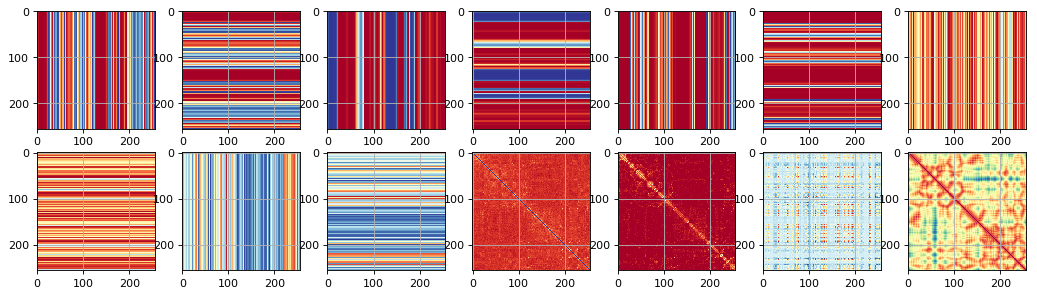

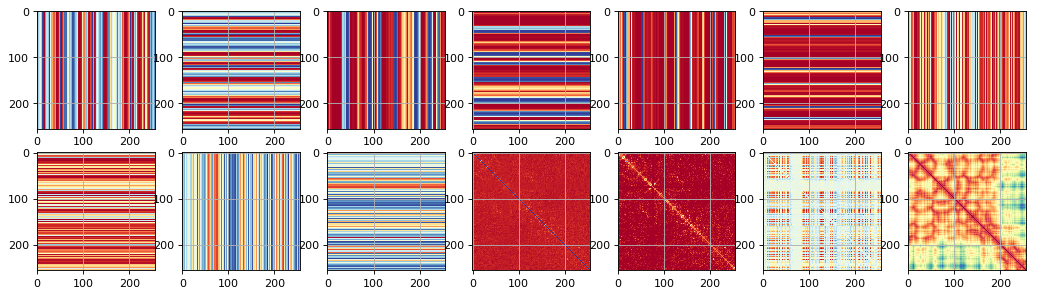

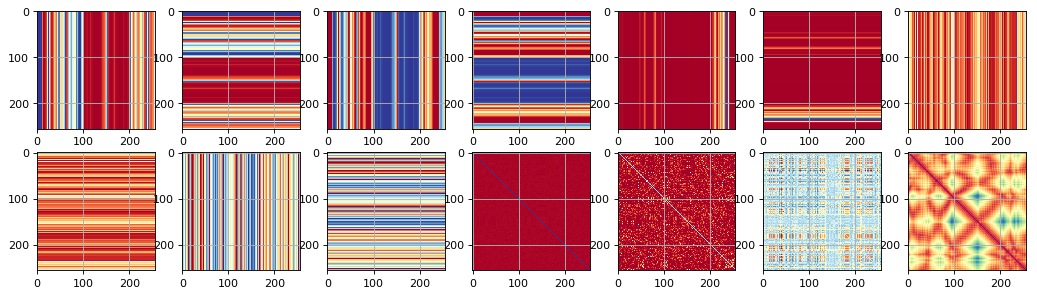

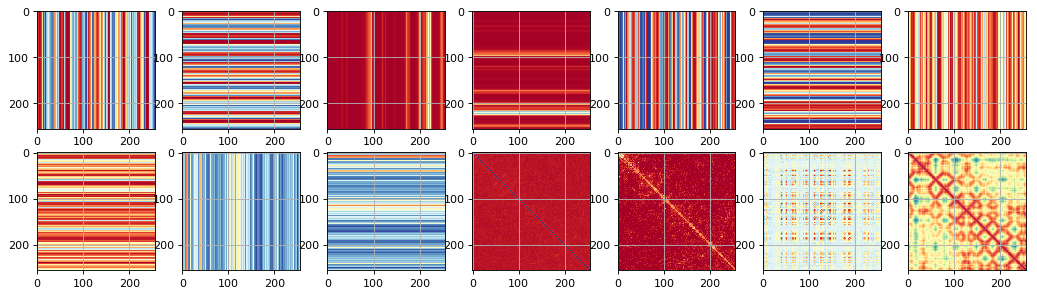

In [12]:
for i in range(4):
    print('')
    L = length_dict[valid_pdbs[i]]
    plot_input_output_of_this_protein(XVALID[i, 0:L, 0:L, :], YVALID[i, 0:L, 0:L, 0])

In [17]:
input_features['1h7cA0']

[array([b'0.997', b'0.910', b'0.753', b'0.426', b'0.336', b'0.300',
        b'0.225', b'0.228', b'0.193', b'0.144', b'0.117', b'0.089',
        b'0.048', b'0.036', b'0.028', b'0.026', b'0.020', b'0.018',
        b'0.025', b'0.021', b'0.029', b'0.045', b'0.021', b'0.008',
        b'0.013', b'0.019', b'0.017', b'0.017', b'0.015', b'0.014',
        b'0.010', b'0.011', b'0.018', b'0.024', b'0.063', b'0.117',
        b'0.112', b'0.122', b'0.278', b'0.681', b'0.869', b'0.975',
        b'0.914', b'0.213', b'0.100', b'0.086', b'0.036', b'0.024',
        b'0.026', b'0.013', b'0.009', b'0.009', b'0.009', b'0.013',
        b'0.022', b'0.044', b'0.059', b'0.152', b'0.243', b'0.321',
        b'0.602', b'0.204', b'0.101', b'0.028', b'0.011', b'0.010',
        b'0.008', b'0.007', b'0.007', b'0.007', b'0.007', b'0.007',
        b'0.008', b'0.008', b'0.011', b'0.011', b'0.018', b'0.026',
        b'0.057', b'0.189', b'0.367', b'0.727', b'0.870', b'0.685',
        b'0.601', b'0.658', b'0.433', b'0.185', 

In [20]:
pdb_1hzf = 'TLEIPGNSDPNMIPDGDFNSYVRVTASDPLDTLGSEGALSPGGVASLLRLPRGCGEQTMIYLAPTLAASRYLDKTEQWSTLPPETKDHAVDLIQKGYMRIQQFRKADGSYAAWLSRDSSTWLTAFVLKVLSLAQEQVGGSPEKLQETSNWLLSQQQADGSFQDPCPVLDRSMQGGLVGNDETVALTAFVTIALHHGLAVFQDEGAEPLKQRVEASISKASSFLGEKASAGLLGAHAAAITAYALTLTKAPADLRGVAHNNLMAMAQETGDNLYWGSVTGSQSNAVSPTPAPRNPSDPMPQAPALWIETTAYALLHLLLHEGKAEMADQASAWLTRQGSFQGGFRSTQDTVIALDALSAYWIASHTTE'

In [21]:
len(pdb_1hzf)

367

In [24]:
test_1hzf = 'TLEIPGNSDPNMIPDGDFNSYVRVTASDPLDTLGSEGALSPGGVASLLRLPRGCGEQTMIYLAPTLAASRYLDKTEQWSTLPPETKDHAVDLIQKGYMRIQQFRKADGSYAAWLSRDSSTWLTAFVLKVLSLAQEQVGGSPEKLQETSNWLLSQQQADGSFQDPCPVLDRSMQGGLVGNDETVALTAFVTIALHHGLAVFQDEGAEPLKQRVEASISKASSFLGEKASAGLLGAHAAAITAYALTLTKAPADLRGVAHNNLMAMAQETGDNLYWGSVTGSQSNAVSPTPAPRNPSDPMPQAPALWIETTAYALLHLLLHEGKAEMADQASAWLTRQGSFQGGFRSTQDTVIALDALSAYWIASHTTE'

pdb_1hzf == test_1hzf

True

In [100]:
(full_pdb_list, full_length_dict, full_input_features) = np.load(full_feature_path, encoding='latin1')
(full_pdb_list_y, full_distance_maps_cb) = np.load(full_distance_path, encoding='latin1')

In [5]:
len(full_pdb_list)

3420

In [8]:
test_features = np.load(test_feature_path, encoding='latin1')
(test_pdb_list_y, test_distance_maps_cb) = np.load(test_distance_path, encoding='latin1')

In [8]:
len(test_pdb_list_y)

150

In [9]:
for feature in full_input_features['1h7cA0']:
    feature = np.array(feature)
    feature = feature.astype(np.float)
    print(feature)

[0.997 0.91  0.753 0.426 0.336 0.3   0.225 0.228 0.193 0.144 0.117 0.089
 0.048 0.036 0.028 0.026 0.02  0.018 0.025 0.021 0.029 0.045 0.021 0.008
 0.013 0.019 0.017 0.017 0.015 0.014 0.01  0.011 0.018 0.024 0.063 0.117
 0.112 0.122 0.278 0.681 0.869 0.975 0.914 0.213 0.1   0.086 0.036 0.024
 0.026 0.013 0.009 0.009 0.009 0.013 0.022 0.044 0.059 0.152 0.243 0.321
 0.602 0.204 0.101 0.028 0.011 0.01  0.008 0.007 0.007 0.007 0.007 0.007
 0.008 0.008 0.011 0.011 0.018 0.026 0.057 0.189 0.367 0.727 0.87  0.685
 0.601 0.658 0.433 0.185 0.034 0.015 0.009 0.008 0.009 0.011 0.013 0.021
 0.031 0.04  0.089 0.172 0.501 0.759 0.974]
[0.002 0.048 0.095 0.248 0.257 0.234 0.294 0.571 0.707 0.847 0.916 0.92
 0.945 0.962 0.976 0.98  0.986 0.988 0.984 0.988 0.985 0.972 0.984 0.994
 0.989 0.983 0.986 0.985 0.987 0.988 0.99  0.989 0.984 0.981 0.962 0.935
 0.885 0.834 0.665 0.238 0.13  0.027 0.045 0.702 0.864 0.871 0.94  0.968
 0.968 0.985 0.99  0.99  0.991 0.988 0.977 0.95  0.925 0.821 0.703 0.621
 0.329 0

In [13]:
dictlist = []
for key, value in input_features.items():
    temp = [key]
    for feature in value:
        feature = np.array(feature)
        feature = feature.astype(np.float)
        temp.append(feature)
    dictlist.append(temp)
test = pd.DataFrame(dictlist)

In [25]:
labels = test[0]
data = test.drop(0, axis=1)

In [28]:
l = full_length_dict['1h7cA0']
print(full_length_dict['1h7cA0'])
print(len(full_input_features['1h7cA0'][0]))
print(len(full_input_features['1h7cA0'][1]))
print(len(full_input_features['1h7cA0'][2]))
print(len(full_input_features['1h7cA0'][3]))
print(len(full_input_features['1h7cA0'][4]))
feat_6 = np.array(full_input_features['1h7cA0'][5].reshape(l, l)).astype(np.float)
feat_7 = np.array(full_input_features['1h7cA0'][6].reshape(l, l)).astype(np.float)
feat_8 = np.array(full_input_features['1h7cA0'][7].reshape(l, l)).astype(np.float)
# for feature in full_input_features['1h7cA0']:
#     feature = np.array(feature)
#     feature = feature.astype(np.float)
#     print(feature)
plt.imshow(feat_6)
plt.show()
plt.imshow(feat_7)
plt.show()
plt.imshow(feat_8)
plt.show()

103
103
103
103
103
103


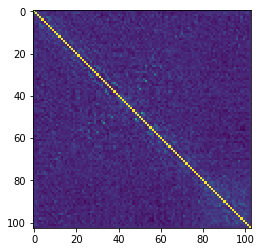

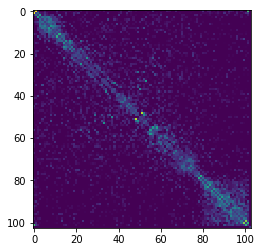

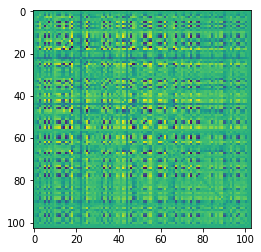

In [30]:
plt.imshow(feat_6)
plt.show()
plt.imshow(feat_7)
plt.show()
plt.imshow(feat_8)
plt.show()

In [5]:
def get_sequence(pdb_id, length):
    url = f'https://www.rcsb.org/pdb/rest/das/pdbchainfeatures/sequence?segment={pdb_id[0:4]}.{pdb_id[4].capitalize()}'
    #print(url)
    resp = requests.get(url)
    tree = ET.ElementTree(ET.fromstring(resp.text))
    root = tree.getroot()
    seq = root[0].text.replace('\n', '').rstrip()
    seq = seq[0:length]
    return [a for a in seq]

def format_features(pdb_id, features, distances, length, labels=None, keep_2d=False):
    feature_count = 0
    feature_arr = {}
    feature_arr['amino_acid'] =  get_sequence(pdb_id, length)
    for feature in features:
        feature = np.array(feature)
        feature = feature.astype(np.float)
        if len(feature) == length:
            if labels:
                feature_arr[f'{labels[feature_count]}'] = feature
            else:
                feature_arr[f'feature_{feature_count}'] = feature
            feature_count +=1
        elif (len(feature) == length * length) & keep_2d:
            f_count = 0
            feature = feature.reshape(length, length)
            for f in feature:
                feature_arr[f'feature_{feature_count}_{f_count}'] = f
                f_count += 1
            feature_count +=1
    distance_count = 0
    for d in distances:
        feature_arr[f'distance_{distance_count}'] = d
        distance_count += 1
    return feature_arr

def extract_features(pdb_list, feature_list, distance_list, length_list, labels=None, keep_2d=False, one_file=False):
    date_time = time.strftime("%Y%m%d-%H%M%S")
    date_path = os.path.join(protein_path, f'Proteins-{date_time}')
    os.mkdir(date_path)
    if one_file:
        p_feats_list = []
        for protein in pdb_list:
            p_feats_list.append(pd.DataFrame(format_features(protein, feature_list[protein], distance_list[protein], length_list[protein], labels, keep_2d)))
        p_feats = pd.concat(p_feats_list, sort=False)
        p_feats.to_csv(os.path.join(date_path, f'All-{date_time}.csv'))
    else:  
        for protein in pdb_list:
            p_feats = format_features(protein, feature_list[protein], distance_list[protein], length_list[protein], labels, keep_2d)
            #print(p_feats)
            p_feats = pd.DataFrame(p_feats)
            #print(p_feats)
            p_feats.to_csv(os.path.join(date_path, f'{protein}-{date_time}.csv'))

In [79]:
(full_pdb_list, full_length_dict, full_input_features) = np.load(full_feature_path, encoding='latin1')
(full_pdb_list_y, full_distance_maps_cb) = np.load(full_distance_path, encoding='latin1')

In [22]:
#test = features_to_file('1h7cA0', full_input_features['1h7cA0'], full_distance_maps_cb['1h7cA0'], full_length_dict['1h7cA0'])
labels = ['PSIPred_1', 'PSIPred_2', 'PSIPred_3', 'PSISolv', 'ShannonEntropySum']
extract_features(full_pdb_list[0:5], full_input_features, full_distance_maps_cb, full_length_dict, None, False, True)

In [28]:
for a in full_pdb_list[0:5]:
    print(a)

stuff = []
for a in full_pdb_list[0:5]:
    stuff.append(get_sequence(a, full_length_dict[a]))

similarities = {}
for i, c in enumerate(stuff[0]):
    if c is stuff[1][i]:
        similarities[i] = c

12asA0
16pkA0
16vpA0
1a0tP0
1a2zA0


In [30]:
similarities

{1: 'K',
 14: 'V',
 27: 'G',
 29: 'I',
 35: 'I',
 37: 'S',
 49: 'G',
 82: 'Q',
 98: 'L',
 133: 'K',
 145: 'A',
 169: 'S',
 179: 'L',
 190: 'K',
 198: 'V',
 226: 'L',
 245: 'A',
 249: 'S'}

In [6]:
url = 'https://www.rcsb.org/pdb/rest/das/pdbchainfeatures/sequence?segment=16pk.A'
resp = requests.get(url)
tree = ET.ElementTree(ET.fromstring(resp.text))
root = tree.getroot()
seq = root[0].text.replace('\n', '').rstrip()
print(seq)

EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKVLTEGGSCVLMSHLGRPKGIPMAQAGKIRSTGGVPGFQQKATLKPVAKRLSELLLRPVTFAPDCLNAADVVSKMSPGDVVLLENVRFYKEEGSKKAKDREAMAKILASYGDVYISDAFGTAHRDSATMTGIPKILGNGAAGYLMEKEISYFAKVLGNPPRPLVAIVGGAKVSDKIQLLDNMLQRIDYLLIGGAMAYTFLKAQGYSIGKSKCEESKLEFARSLLKKAEDRKVQVILPIDHVCHTEFKAVDSPLITEDQNIPEGHMALDIGPKTIEKYVQTIGKCKSAIWNGPMGVFEMVPYSKGTFAIAKAMGRGTHEHGLMSIIGGGDSASAAELSGEAKRMSHVSTGGGASLELLEGKTLPGVTVLDDK


In [28]:
test2 = [p for p in full_pdb_list if p[-1] != '0']

In [14]:
test = [p for p in full_pdb_list if '1p5d' in p]

In [15]:
test

['1p5dX0']

In [16]:
p_1p5d = '''MSTAKAPTLPASIFRAYDIRGVVGDTLTAETAYWIGRAIGSESLARGEPCVAVGRDGRLSGPELVKQLIQGLVDCGCQVS
DVGMVPTPVLYYAANVLEGKSGVMLTGSHNPPDYNGFKIVVAGETLANEQIQALRERIEKNDLASGVGSVEQVDILPRYF
KQIRDDIAMAKPMKVVVDCGNGVAGVIAPQLIEALGCSVIPLYCEVDGNFPNHHPDPGKPENLKDLIAKVKAENADLGLA
FDGDGDRVGVVTNTGTIIYPDRLLMLFAKDVVSRNPGADIIFDVKCTRRLIALISGYGGRPVMWKTGHSLIKKKMKETGA
LLAGEMSGHVFFKERWFGFDDGIYSAARLLEILSQDQRDSEHVFSAFPSDISTPEINITVTEDSKFAIIEALQRDAQWGE
GNITTLDGVRVDYPKGWGLVRASNTTPVLVLRFEADTEEELERIKTVFRNQLKAVDSSLPVPF'''

In [29]:
test2

[]

###########################################################################################################
# Start Here #
This is where the code for torsion angles and ramachandran plots are <br>
###########################################################################################################

In [143]:
def get_ground_truth_deprecated(full_pdb_id, degrees=False):
    pdb_id = full_pdb_id[0:4]
    pdb_struct = get_pdb_structure(pdb_id)  # Returns the BioPython structure of the PDB file
    pdb_id = pdb_id.upper()
    ss_df = get_secondary_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            phi_psi = []
            residues = [r for r in chain if Polypeptide.is_aa(r)]
            lng = len(residues)
            for i in range(0, lng):
                res = residues[i]
                try:
                    n = res['N'].get_vector()
                    ca = res['CA'].get_vector()
                    c = res['C'].get_vector()
                except Exception:
                    # Some atoms are missing
                    # Phi/Psi cannot be calculated for this residue
                    phi_psi.append((None, None))
                    continue
                # Phi
                if i > 0:
                    rp = residues[i - 1]
                    try:
                        cp = rp['C'].get_vector()
                        phi = calc_dihedral(cp, n, ca, c)
                    except Exception:
                        phi = None
                else:
                    # No phi for residue 0!
                    phi = None
                # Psi
                if i < (lng - 1):
                    rn = residues[i + 1]
                    try:
                        nn = rn['N'].get_vector()
                        psi = calc_dihedral(n, ca, c, nn)
                    except Exception:
                        psi = None
                else:
                    # No psi for last residue!
                    psi = None
                phi_psi.append((phi, psi))
            for res_index, residue in enumerate(residues):
                #res_name = "%s%i" % (residue.resname, residue.id[1])
                #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                deg = phi_psi[res_index]
                if degrees:
                    deg = tuple(math.degrees(b) if b else None for b in deg)
                phi, psi = deg
                model_name, model_id = model.full_id
                torsion_angles.append([model_name, model_id, chain.id,
                    residue.resname, residue.id[1], phi, psi])
    torsion_df = pd.DataFrame(torsion_angles, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 
        'Residue_ID', 'Phi', 'Psi']).fillna(0)
    
    print(len(torsion_df[torsion_df['Chain'] == full_pdb_id[4]]))
    print(len(ss_df[ss_df['Chain'] == full_pdb_id[4]]))
    return torsion_df[torsion_df['Chain'] == full_pdb_id[4]], ss_df[ss_df['Chain'] == full_pdb_id[4]]

def ramachandran_plot(pdb_id, degrees=True):
    df = get_ground_truth(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id, file_path)
    except Exception as e:
        print(e)
        return None
    return struct

def get_pdb_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    #print(url)
    resp = requests.get(url)
    try:
        file_path = os.path.join(pdb_path, f'{pdb_id}.pdb')
        if os.path.isfile(file_path) and not replace:
            return True
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view

def get_pdb_ss_seq(pdb_id):
    ss_txt = open(ss_path).read()
    ss_txt = ss_txt.replace('\n', "")
    ss = []
    offs = -1
    pdb_length = -1
    prev_seq = ''
    while True:
        offs = ss_txt.find(pdb_id, offs + 1)
        if offs == -1:
            break
        elif ss_txt[offs+7:offs+15] == 'sequence':
            next_offs = ss_txt.find(pdb_id, offs + 1)
            diff = next_offs - offs
            pdb_length = diff
            prev_seq = ss_txt[offs + 15:offs + pdb_length - 1]
        else:
            ss.append([ss_txt[offs+5], prev_seq, ss_txt[offs + 13:offs + pdb_length - 3]])
    return ss

def get_secondary_structure(pdb_id):
    pdb_id = pdb_id.upper()
    indexes = get_pdb_ss_seq(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        #unknown_list = [i for i, c in enumerate(seq) if c == 'X']
        #print(unknown_list)
        seq_list = [c for c in seq]
        # [f(x) if condition else g(x) for x in sequence]
        ss_list = ['L' if c is ' ' else c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'Chain': chain_id, 'Amino_Acid':seq_list, 'Secondary_Structure':ss_list}))
    return pd.concat(chain_df)

def get_cb_distances(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    pdb_struct = get_pdb_structure(pdb_id)  # Returns the BioPython structure of the PDB file
    ppb = PPBuilder()
    chain_dist_matrix = {}
    for model in pdb_struct:
        for chain in model:
            residues = []
            for pp in ppb.build_peptides(chain, aa_only=False):
                for residue in pp:
                    residues.append(residue)
            lng = len(residues)
            dist_matrix = np.zeros((lng, lng), np.float)
            for i in range(0, lng):
                for j in range(i, lng):
                    try:
                        diff_vector  = residues[i]['C'].coord - residues[j]['C'].coord
                    except Exception:
    #                         print(residues[j].resname)
    #                         atoms = [a for a in residues[j]]
    #                         print(atoms)
                        # This just gets the average value around the unknown residue distance
                        count = 0
                        sums = 0
                        if j - 1 >= 0:
                            count += 1
                            sums += chain_dist_matrix[i][j - 1]
                        if i - 1 >= 0:
                            count += 1
                            sums += chain_dist_matrix[i - 1][j]
                        if count > 0:
                            diff_vector = sums / count
                        else:
                            diff_vector = 0
                    dist = np.sqrt(np.sum(diff_vector * diff_vector))
                    dist_matrix[i][j] = dist
                    dist_matrix[j][i] = dist
                chain_dist_matrix[chain.id] = dist_matrix
        
    if partial:
        start_pos, end_pos = get_seq_pos(full_pdb_id)
        dist_matrix = chain_dist_matrix[full_pdb_id[4].upper()]
        return pd.DataFrame(dist_matrix[start_pos:end_pos]).iloc[:, start_pos:end_pos]
    else:
        return chain_dist_matrix

def get_seq_alignment(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = record.seq
    pdb_id = full_pdb_id[0:4].upper()
    #print(pdb_id)
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                alignments = pairwise2.align.globalxx(ground_seq, str(seq))
                al_seq = alignments[0][1]
                al_seq_bool = [False if a is '-' else True for a in al_seq]
                return al_seq_bool
            #print(format_alignment(*alignments[0]))

def get_seq_pos(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = str(record.seq)
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                start_pos = ground_seq.find(seq)
                end_pos = start_pos + len(seq)
                return (start_pos, end_pos)
            
def pdb_id_to_dssp_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    rest_url = 'http://www.cmbi.umcn.nl/xssp/'
    # Read the pdb id data into a variable
    data = {'data': pdb_id}

    # Send a request to the server to create hssp data from the pdb file data.
    # If an error occurs, an exception is raised and the program exits. If the
    # request is successful, the id of the job running on the server is
    # returned.
    url_create = f'{rest_url}api/create/pdb_id/dssp/'
    r = requests.post(url_create, data=data)
    r.raise_for_status()

    job_id = json.loads(r.text)['id']
    #print(f'Job submitted successfully. Id is: {job_id}')

    # Loop until the job running on the server has finished, either successfully
    # or due to an error.
    ready = False
    while not ready:
        # Check the status of the running job. If an error occurs an exception
        # is raised and the program exits. If the request is successful, the
        # status is returned.
        url_status = f'{rest_url}api/status/pdb_id/dssp/{job_id}/'
        r = requests.get(url_status)
        r.raise_for_status()

        status = json.loads(r.text)['status']
        #print(f'Job status is: {status}')

        # If the status equals SUCCESS, exit out of the loop by changing the
        # condition ready. This causes the code to drop into the `else` block
        # below.
        #
        # If the status equals either FAILURE or REVOKED, an exception is raised
        # containing the error message. The program exits.
        #
        # Otherwise, wait for five seconds and start at the beginning of the
        # loop again.
        if status == 'SUCCESS':
            ready = True
        elif status in ['FAILURE', 'REVOKED']:
            raise Exception(json.loads(r.text)['message'])
        else:
            time.sleep(5)
    else:
        # Requests the result of the job. If an error occurs an exception is
        # raised and the program exits. If the request is successful, the result
        # is returned.
        url_result = f'{rest_url}api/result/pdb_id/dssp/{job_id}/'
        r = requests.get(url_result)
        r.raise_for_status()
        result = json.loads(r.text)['result']
        try:
            file_path = os.path.join(dssp_path, f'{pdb_id}.dssp')
            if os.path.isfile(file_path) and not replace:
                return True
            #print(file_path)
            file = open(file_path, "w")
            file.write(result)
            file.close()
        except Exception as e: 
            print(e)
            return False
        # Return the result to the caller, which prints it to the screen.
        return True

def get_ground_truth_api(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    struct_info = []
    seq_count = 0
    for model in struct:
        file = os.path.join(pdb_path, f'{pdb_id}.pdb')
        pdb_id_to_dssp_file(pdb_id)
        dssp = DSSP(model=model, in_file=os.path.join(dssp_path, f'{pdb_id}.dssp'), file_type='DSSP')
        seq_count = 0
        #dssp = DSSP(model=model, in_file=file)
        for chain in model:
            residues = []
            seq = ''
            for pp in ppb.build_peptides(chain, aa_only=False):
                seq += pp.get_sequence()
                for residue in pp:
                    residues.append(residue)
            for i, residue in enumerate(residues):
                try:
                    key = list(dssp.keys())[seq_count]   
                    dssp_info = dssp[key]
                    amino_acid = dssp_info[1]
                    sec_struct = dssp_info[2]
                    solv_acc = dssp_info[3]
                    phi = dssp_info[4]
                    psi = dssp_info[5]
                except Exception:
                    # DSSP didn't capture this amino acid
                    #print(full_pdb_id, seq_count, len(dssp), len(seq), residue)
                    amino_acid = seq[i]
                    sec_struct = '-'
                    solv_acc = 0
                    phi = 360
                    psi = 360
                seq_count += 1
                # Keys 6 through 13 is bonding energy / relidx (no clue what this is)
                struct_info.append([model.full_id[0], model.full_id[1], chain.id,
                    residue.resname, residue.id[1], amino_acid, sec_struct, solv_acc, phi, psi])
    info_df = pd.DataFrame(struct_info, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name',
        'Residue_ID', 'Amino_Acid', 'Secondary_Structure', 'Solvent_Accessability', 
        'Phi', 'Psi'])
    if partial:    
        start_pos, end_pos = get_seq_pos(full_pdb_id)
        fin_df = info_df[info_df['Chain'] == full_pdb_id[4].upper()]
        return fin_df[start_pos:end_pos]
    else:
        return info_df

def get_ground_truth(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    struct_info = []
    for model in struct:
        file = os.path.join(pdb_path, f'{pdb_id}.pdb')
        dssp = DSSP(model=model, in_file=file)
        seq_count = 0
        for chain in model:
            for pp in ppb.build_peptides(chain, aa_only=False):
                seq = pp.get_sequence()
                for residue in pp:
                    #print(residue.id[1], seq[i])
                    try:
                        dssp_info = dssp[dssp.keys()[seq_count]]
                    except Exception:
                        print(len(seq), len(dssp))
                    seq_count += 1
                    #dssp_id = dssp_info[0]
                    amino_acid = dssp_info[1]
                    sec_struct = dssp_info[2]
                    solv_acc = dssp_info[3]
                    phi = dssp_info[4]
                    psi = dssp_info[5]
                    # Keys 6 through 13 is bonding energy / relidx (no clue what this is)
                    #print(dssp[dssp.keys()[i]])
                    struct_info.append([model.full_id[0], model.full_id[1], chain.id,
                    residue.resname, residue.id[1], amino_acid, sec_struct, solv_acc, phi, psi])
    info_df = pd.DataFrame(struct_info, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name',
        'Residue_ID', 'Amino_Acid', 'Secondary_Structure', 'Solvent_Accessability', 
        'Phi', 'Psi'])
    
    if partial:    
        start_pos, end_pos = get_seq_pos(full_pdb_id)
        fin_df = info_df[info_df['Chain'] == full_pdb_id[4].upper()]
        return fin_df[start_pos:end_pos]
    else:
        return info_df

In [142]:
dfs = []
print(full_pdb_list.index('1efuD0'))
for full_pdb_id in full_pdb_list[76:200]:
    dfs.append(get_ground_truth_api(full_pdb_id, partial=True))
    #print(is_seq_contained(full_pdb_id))

77
1efuD0 1290 1290 282 <Residue GLN het=  resseq=281 icode= >
1efuD0 1291 1290 282 <Residue SER het=  resseq=282 icode= >
1gflB0 458 458 230 <Residue ILE het=  resseq=229 icode= >
1gflB0 459 458 230 <Residue THR het=  resseq=230 icode= >
1h12A0 403 403 404 <Residue PHE het=  resseq=404 icode= >
1h3oB0 246 246 74 <Residue TRP het=  resseq=127 icode= >
1h3oB0 247 246 74 <Residue ILE het=  resseq=128 icode= >
1hbnB0 2472 2472 247 <Residue ASN het=  resseq=247 icode= >
1hbnB0 2473 2472 247 <Residue LEU het=  resseq=248 icode= >
1hfeS0 968 968 397 <Residue ALA het=  resseq=397 icode= >
1hfeS0 969 968 397 <Residue MET het=  resseq=398 icode= >
1hlqA0 222 222 74 <Residue LYS het=  resseq=74 icode= >


In [129]:
dfs[0]

,Model_Name,Model_ID,Chain,Residue_Name,Residue_ID,Amino_Acid,Secondary_Structure,Solvent_Accessability,Phi,Psi
0,1AOL,0,A,GLN,9,Q,-,0.570707,360.0,126.3
1,1AOL,0,A,VAL,10,V,E,0.464789,-88.1,138.2
2,1AOL,0,A,TYR,11,Y,E,0.184685,-123.7,157.5
3,1AOL,0,A,ASN,12,N,E,0.216561,-81.2,99.8
4,1AOL,0,A,ILE,13,I,E,0.023669,-84.9,122.8
5,1AOL,0,A,THR,14,T,E,0.091549,-115.9,127.3
6,1AOL,0,A,TRP,15,W,E,0.013216,-98.9,119.3
7,1AOL,0,A,GLU,16,E,E,0.170103,-109.9,143.2
8,1AOL,0,A,VAL,17,V,E,0.000000,-116.3,135.5
9,1AOL,0,A,THR,18,T,E,0.007042,-117.7,160.0


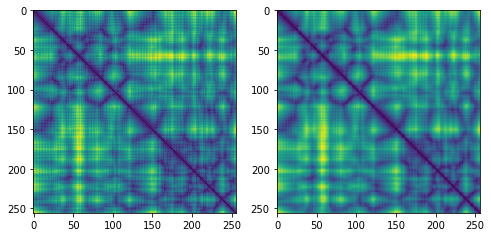

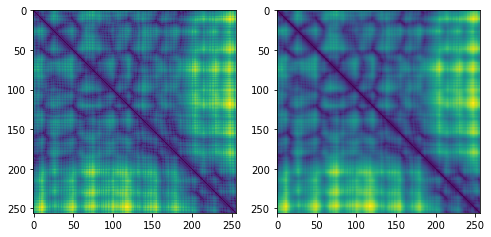

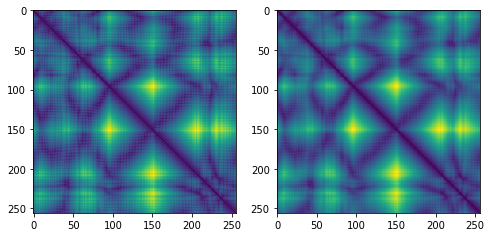

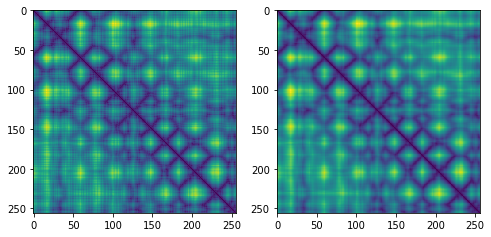

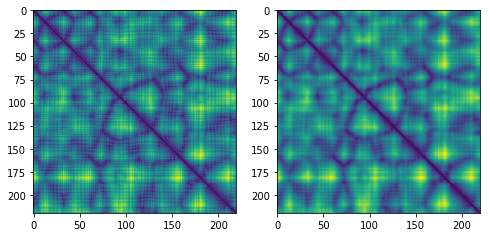

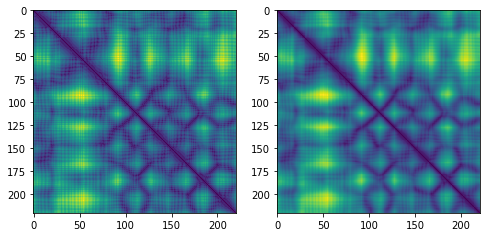

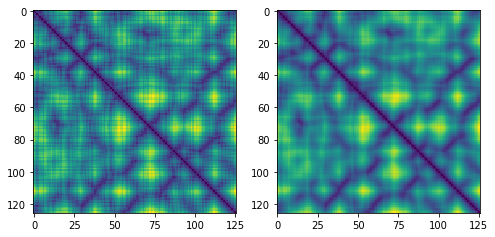

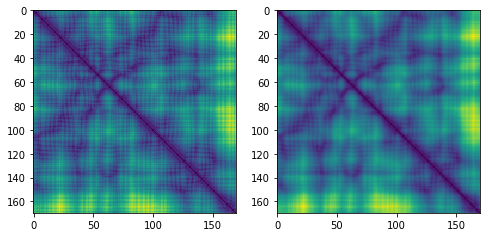

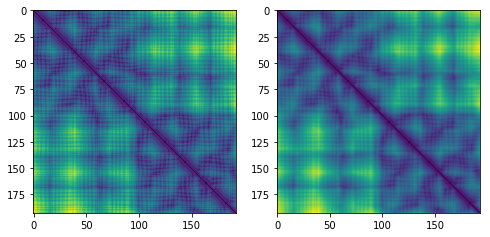

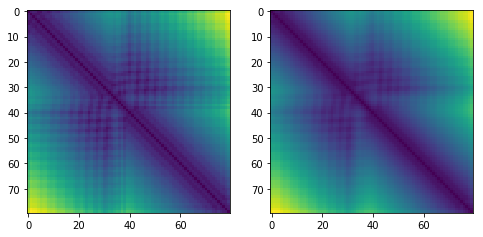

In [92]:
# d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
#      'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
#      'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
#      'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M', 
#      'ASX': 'B', 'XLE': 'J', 'PYL': 'O', 'SEC': 'U', 'XAA': 'X', 
#      'GLX': 'Z', 'MSE': 'M', 'AMP': 'X', 'BIS': 'X'}

for i in range(0, 10):
    pdb3_id = pdb_list[i]
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(distance_maps_cb[pdb3_id])
    fig.add_subplot(1, 2, 2)
    plt.imshow(get_cb_distances(pdb3_id, partial=True))
    plt.show()

# for i in range(0, 10):
#     pdb3_id = pdb_list[i]
#     fig=plt.figure(figsize=(16, 16))
#     plt.imshow(distance_maps_cb[pdb3_id] - get_cb_distances(pdb3_id, partial=True))
#     plt.show()

In [14]:
#pdb_id_to_dssp_file(pdb_list[0][0:4])
#dssp = make_dssp_dict(os.path.join(dssp_path, f'{pdb_list[0][0:4].upper()}.dssp'))
# model = get_pdb_structure(pdb_list[0][0:4])[0]
# file = os.path.join(pdb_path, f'{pdb_list[0][0:4].upper()}.pdb')
# dssp = DSSP(model=model, in_file=file)

# a_key = dssp.keys()[0]
# print(a_key)
# a_value = dssp[a_key]
# print(a_value)

654
654
415
415
311
311
1239
1239
880
880
3315
3315
378
378
676
676
374
374
313
313


In [9]:
# this generates the secondary structure ground truth for a protein
# for a certain range(start,stop) of amino acids

def ss_ground_truth(protein_id, aa_range,secs):

    sstructs="HBEGITS"

    

    k=secs[secs['Chain']==protein_id[4]]
    k=k.loc[aa_range,:]

    ss_count=[]

    for ss in sstructs:
        ss_count.append(len(k[k['Secondary_Structure']==ss])/len(k))

    return ss_count


# H = alpha helix
# B = residue in isolated beta-bridge
# E = extended strand, participates in beta ladder
# G = 3-helix (3/10 helix)
# I = 5 helix (pi helix)
# T = hydrogen bonded turn
# S = bend

In [46]:
#define functions

def mean(numlist):
    return sum(numlist)/len(numlist)

def chip_diagonal(chip_size, step_size, aa_length):
    tri=[]
    for diag in range(0,aa_length-chip_size,step_size):
        tri.append(
            [(y,x) for y in range(diag,diag+chip_size) for x in range(y+1,chip_size+diag+1)]
        )
        # NB: y already has diag added to it
    return tri


def gif_from_tri(protein_id,tri,filename):
    
    protein = np.array(distance_maps_cb[protein_id])
    l=len(protein)

    gif=[]

    for t in tri:
        new_test=np.ones((l,l))*0
        for (y,x) in t:
            new_test[y,x]=protein[y,x]

        im=plt.imshow(new_test)

        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=5)

    
def diag_chips_to_df(protein_id, chip_size, step_size):
    get_pdb_file(protein_id[0:4])
    protein_dist = np.array(distance_maps_cb[protein_id])
    aa_length=len(protein_dist[0])
    
    protein_feat = np.array(input_features[protein_id])

    ccmpred=protein_feat[5].astype(np.float)
    ccmpred.shape=(aa_length,aa_length)
    
    freecontact=protein_feat[6].astype(np.float)
    freecontact.shape=(aa_length,aa_length)
    
    pstat_pots=protein_feat[7].astype(np.float)
    pstat_pots.shape=(aa_length,aa_length)
    
    chips=chip_diagonal(chip_size, step_size, aa_length)
    ground_truth = get_ground_truth(protein_id[0:4])
    if len(ground_truth) == 0:
        return pd.DataFrame()
    phi_angles = np.array(ground_truth['Phi'])
    psi_angles = np.array(ground_truth['Psi'])  
    cols=["protein_id","chip_id"]
    cols+=["dist_"+str(n) for n in range(0,len(chips[0]))]
    cols+=["psipred_helix","psipred_sheet","psipred_coil"]
    cols+=["psisolv","shannon_entropy"]
    cols+=['phi', 'psi']
    cols+=["ccmpred","freecontact","pstat_pots"]
    cols+=["ground_truth_"+x for x in "HBEGITS"]
    
    chiplist=[]
    
    # loop through all the chips
    for i in range(0,len(chips)):
        
        # row identifiers
        row=[protein_id,"chip_"+str(i)]
        
        incl_range=range(min(min(chips[i])),max(max(chips[i])))
        
        # 1d features
        psipred_helix=mean(protein_feat[0].astype(np.float)[incl_range])
        psipred_sheet=mean(protein_feat[1].astype(np.float)[incl_range])
        psipred_coil=mean(protein_feat[2].astype(np.float)[incl_range])
        psisolv=mean(protein_feat[3].astype(np.float)[incl_range])
        shannon_entropy=mean(protein_feat[4].astype(np.float)[incl_range])
        phi_angle=mean(phi_angles[incl_range])
        psi_angle=mean(psi_angles[incl_range])
        
        # 2d features
        ccmpred_pool=[]
        freecontact_pool=[]
        pstat_pool=[]
        
        # ss ground truth
        ssgt=ss_ground_truth(protein_id,incl_range,ground_truth)
        
        # loop through each pixel in the chip
        for n in range(0,len(chips[i])):
            
#             make sure we're not on the diagonal
#             print([chips[i][n][0],chips[i][n][1]])
            
            row.append(
                protein_dist[chips[i][n][0],chips[i][n][1]]
            )
            ccmpred_pool.append(
                ccmpred[chips[i][n][0],chips[i][n][1]]
            )
            freecontact_pool.append(
                freecontact[chips[i][n][0],chips[i][n][1]]
            )
            pstat_pool.append(
                pstat_pots[chips[i][n][0],chips[i][n][1]]
            )
            
        # 1d features
        row.append(psipred_helix)
        row.append(psipred_sheet)
        row.append(psipred_coil)
        row.append(psisolv)
        row.append(shannon_entropy)
        row.append(phi_angle)
        row.append(psi_angle)
   
        # 2d features
        row.append(max(ccmpred_pool))
        row.append(max(freecontact_pool))
        row.append(max(pstat_pool))
        
        # ground truth
        [row.append(x) for x in ssgt]
        
        # add to df
        chiplist.append(row)
    chip_df=pd.DataFrame(chiplist,columns=cols)

    return chip_df

# compute the ground truth secondary structure
# of which the majority of amino acids in a window
# are a part of
# i.e. that whose percentage within the window is above 50%
def compute_majority_ss(df):
    for ss in "HBEGITS":
        df["maj_"+ss] = (df['ground_truth_'+ss]>.5).astype(int)
    return df

In [11]:
# some variable sizes

chip_size=10
step_size=1


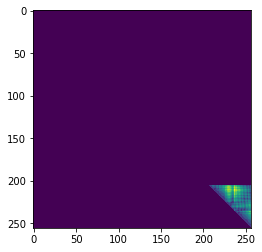

In [64]:
# demonstrate the gif function

gif_from_tri("1hzfA0",chip_diagonal(50,1,256),"chiptri_diag")

In [47]:
# demonstrate how to create a dataset from it

#dataset=pd.concat([(diag_chips_to_df(pid,10,1)) for pid in pdb_list[0:20]])
compute_majority_ss(dataset)
#dataset.to_csv(os.path.join(data_path, "protein_test_torsion.csv"))
#pd.get_dummies(dataset.T).to_csv(os.path.join(data_path, "protein_torsions_v2.csv"))

,protein_id,chip_id,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,...,ground_truth_I,ground_truth_T,ground_truth_S,maj_H,maj_B,maj_E,maj_G,maj_I,maj_T,maj_S
0,16pkA0,chip_0,5.209237,8.680108,9.888624,14.776792,13.726695,11.585502,15.590197,19.692793,...,0.0,0.0,0.1,0,0,0,0,0,0,0
1,16pkA0,chip_1,5.577346,6.872610,10.821810,11.587453,9.606672,11.961372,16.680738,16.934675,...,0.0,0.1,0.1,0,0,0,0,0,0,0
2,16pkA0,chip_2,5.777115,8.543923,8.955521,5.063752,7.300178,11.334828,12.669797,16.996637,...,0.0,0.2,0.1,0,0,0,0,0,0,0
3,16pkA0,chip_3,5.163104,4.913408,5.542104,7.743250,12.815974,11.814922,16.652194,18.804593,...,0.0,0.2,0.1,0,0,0,0,0,0,0
4,16pkA0,chip_4,5.523897,7.429766,5.509554,10.656823,7.630220,12.999610,14.629657,11.246587,...,0.0,0.2,0.1,0,0,0,0,0,0,0
5,16pkA0,chip_5,5.328158,7.378950,11.200550,9.862825,13.726993,16.809807,14.310917,18.708033,...,0.0,0.2,0.1,0,0,0,0,0,0,0
6,16pkA0,chip_6,5.623469,8.852339,10.251569,13.790733,16.474596,13.362002,18.089599,13.544215,...,0.0,0.2,0.1,0,0,0,0,0,0,0
7,16pkA0,chip_7,5.514157,5.408250,9.925838,11.553241,7.928687,12.483046,8.136685,11.630719,...,0.0,0.2,0.1,0,0,0,0,0,0,0
8,16pkA0,chip_8,5.884653,6.698126,8.636930,6.593886,12.088447,10.196181,14.097409,15.058727,...,0.0,0.2,0.0,0,0,0,0,0,0,0
9,16pkA0,chip_9,5.664666,7.148151,5.017018,9.698557,6.109954,11.561506,10.775781,15.582966,...,0.0,0.2,0.0,0,0,1,0,0,0,0


In [49]:
pd.get_dummies(dataset.drop(['chip_id'], axis=1)).T.to_csv(os.path.join(data_path, "protein_torsions_v2.csv"))

In [12]:
# this will add majority secondary structure to the dataframe
# through loading it from file
# i've dummied it out through the if statement but its still usefull
if False:
    dataset=pandas.read_csv("datasets/protein_full_gt.csv")

    compute_majority_ss(dataset)
    dataset.to_csv("datasets/protein_full_gt_classed.csv")



In [13]:
# these generate triangular numbers from a row number
# and row numbers from a triangular number
# not sure if I use them anymore but here they are
def tri_num(x):
    return x*(x+1)/2
    
def inv_tri_num(x):
    for i in range(0,x):
        if tri_num(i)>x:
            return None
        if tri_num(i)==x:
            return i    

In [14]:
# this draws a gif from a number of chips l
# which will iterate through the rows of a datafile
# and make each row (and the chip represented by that row)
# into a frame of the gif
def gif_from_chips(dataset,l,filename):    

    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    gif=[]

    for n in range(0,l):
        
        chpx=list(df.iloc[n,:])

        chip_l=inv_tri_num(ncol)+1
        chp_im=np.zeros((chip_l,chip_l))
        triu=np.triu_indices(chip_l,1)
        tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]

        for i in range(0,len(tri_ind)):
             chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

        im=plt.imshow(chp_im)    

        
        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=60)

    
    
# this is a function which will draw the average chip
# of a dataset
# i.e. draw a chip whose pixels are each an average of the
# pixels in that position on each chip
def draw_avg_chip(dataset, name, max_dist):
    
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
#     print(ncol)
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.zeros((chip_l,chip_l))
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

    im=plt.imshow(chp_im,vmax=max_dist)
    
    x=im.make_image("AGG")[0]
    x=np.flipud(x)
    
    imageio.imsave("plots/"+name+".png", x)

In [19]:
# read in the dataset to use below
dataset=pd.read_csv(os.path.join(data_path, "protein_test_gt.csv"))

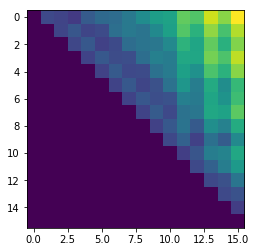

In [20]:
# demonstrate the gif_from_chips function
# which draws an animated gif of a number of chips from a saved dataset

gif_from_chips(dataset,500,"chip_draw")

In [22]:
# this draws the avg distance for each pixel in all chips
# within each point in a thd dendrogram

def draw_thd_segmentations(folder,dataset,max_dist):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:10]=="thd_test_ "]

    thds

    for model in thds:
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)
            draw_avg_chip(dataset.iloc[[int(m) for m in a['nodeRows']],:],model[10:len(model)-5],max_dist)


In [23]:
# demonstrate draw_thd_segmentations

#     draw_thd_segmentations("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ",dataset)

draw_thd_segmentations("THD_test_Absolute Correlation_protein_test_fifteen_gt.csv_2019.06.19 14.20.55/","THD_test ",dataset)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'datasets/THD_test_Absolute Correlation_protein_test_fifteen_gt.csv_2019.06.19 14.20.55/'

In [ ]:
! conda install -c salilab -c speleo3 dssp 